<center>
    <br />
    <h1>An introduction to Machine Learning with Scikit-Learn</h1>
    <br /><br />
   Yifei Huang
    <br /><br />
    MAFS6010U
    <br /><br />
    HKUST
</center>

## Prerequisites 

- Materials available on  <a href="https://piazza.com/ust.hk/spring2019/mafs6010u/resources">Piazza</a>
    
- Require a Python distribution with scientific packages (NumPy, SciPy, Scikit-Learn, Pandas)


# Outline

* Preprocess data with Pandas and Numpy in Python
* Scikit-Learn and Machine Learning in Python
* Various Classification Models
* Model evaluation and selection
* Summary

### Load some packages

In [1]:
import sklearn
import numpy as np
import pandas as pd
try:
    from mpl_finance import candlestick_ohlc
except ImportError:
    ! pip install mpl_finance
    from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn')

### Loading external data with pandas

In [2]:
data=pd.read_csv('./okex_future_BTC_USD_this_week_1H.csv',parse_dates=['candle_begin_time'])

In [3]:
data.head()

,candle_begin_time,open,high,low,close,volume
0,2018-05-15 00:00:00,8674.33,8761.76,8663.17,8696.66,172152.0
1,2018-05-15 01:00:00,8694.66,8728.17,8662.17,8701.85,122668.0
2,2018-05-15 02:00:00,8699.98,8741.04,8642.36,8673.34,181228.0
3,2018-05-15 03:00:00,8673.19,8717.70,8638.95,8707.10,193166.0
4,2018-05-15 04:00:00,8710.92,8737.36,8684.20,8699.16,155912.0


### Visualization

Text(0.5, 0, 'Date')

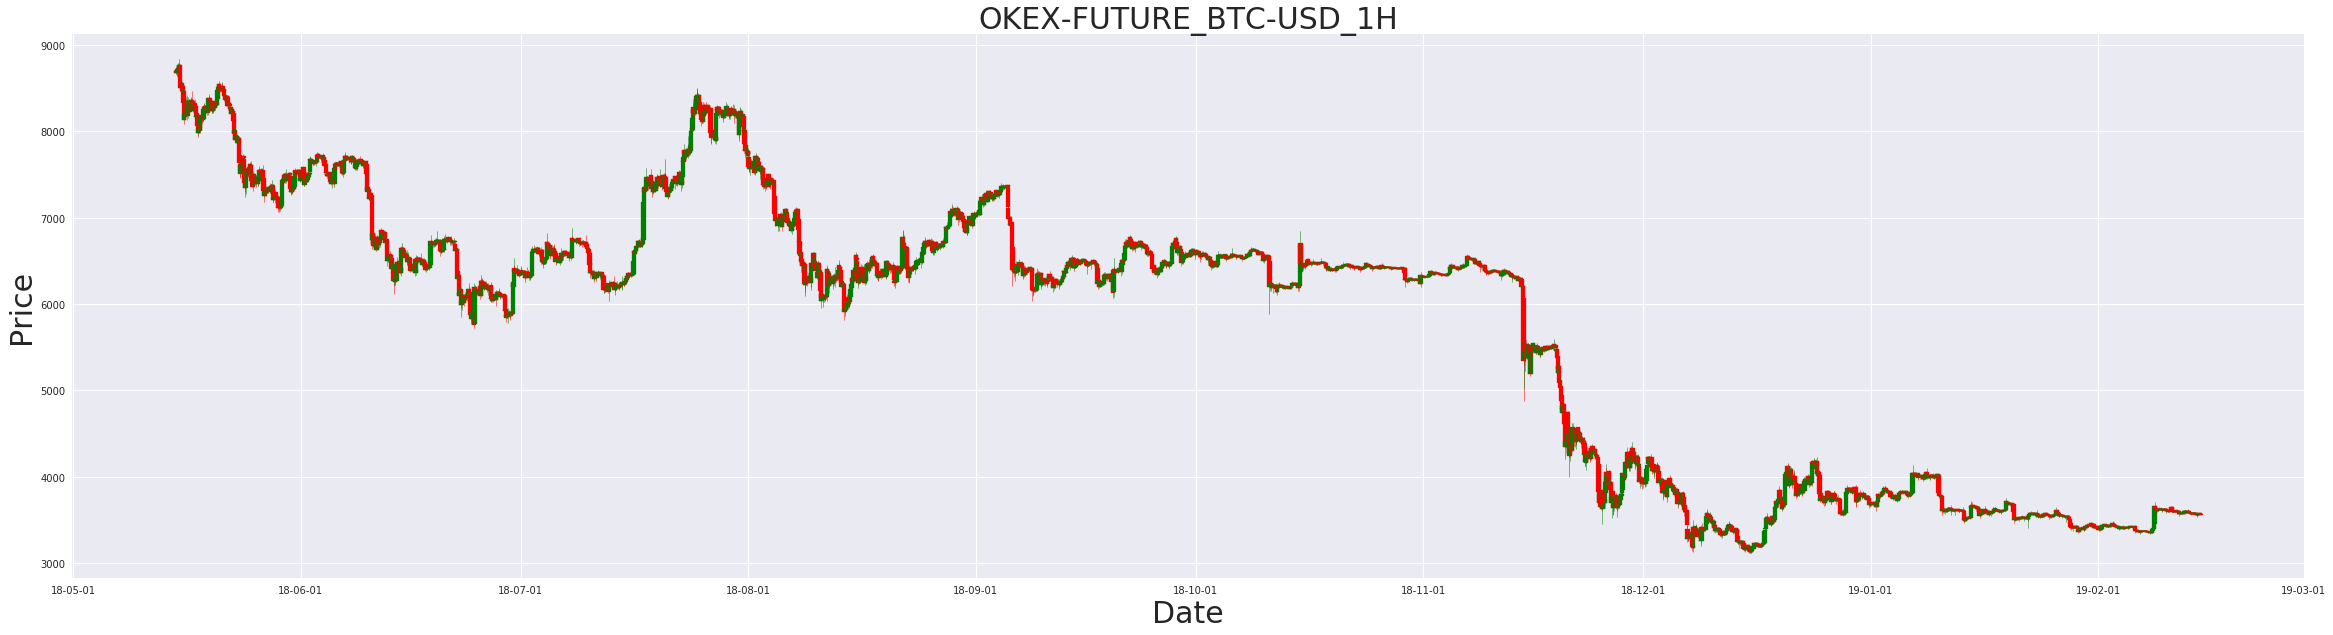

In [4]:
data['timestamp']=data.candle_begin_time.apply(mdates.date2num)
fig,ax=plt.subplots(1,1,figsize=(40,10))
plt.title('OKEX-FUTURE_BTC-USD_1H',fontsize=30)
candlestick_ohlc(ax,data[['timestamp','open','high','low','close']].values,width=.6,colorup='g',alpha=1)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
ax.set_ylabel('Price',fontdict={'size':30})
ax.set_xlabel('Date',fontdict={'size':30})

### What we want to do is to predict the next price down or up based on last price

In [5]:
data['down_or_up']=np.sign(data.close.diff().shift(-1))
data=data.dropna()

In [6]:
data.head()

,candle_begin_time,open,high,low,close,volume,timestamp,down_or_up
0,2018-05-15 00:00:00,8674.33,8761.76,8663.17,8696.66,172152.0,736829.000000,1.0
1,2018-05-15 01:00:00,8694.66,8728.17,8662.17,8701.85,122668.0,736829.041667,-1.0
2,2018-05-15 02:00:00,8699.98,8741.04,8642.36,8673.34,181228.0,736829.083333,1.0
3,2018-05-15 03:00:00,8673.19,8717.70,8638.95,8707.10,193166.0,736829.125000,-1.0
4,2018-05-15 04:00:00,8710.92,8737.36,8684.20,8699.16,155912.0,736829.166667,1.0


In [7]:
data.tail()

,candle_begin_time,open,high,low,close,volume,timestamp,down_or_up
6618,2019-02-14 18:00:00,3574.04,3576.45,3573.22,3575.91,210.194723,737104.750000,-1.0
6619,2019-02-14 19:00:00,3576.18,3577.88,3571.17,3574.89,164.462093,737104.791667,-1.0
6620,2019-02-14 20:00:00,3576.06,3576.06,3563.81,3566.38,178.780002,737104.833333,1.0
6621,2019-02-14 21:00:00,3565.87,3575.20,3556.68,3572.00,218.644452,737104.875000,-1.0
6622,2019-02-14 22:00:00,3570.56,3572.85,3564.21,3566.40,192.240609,737104.916667,-1.0


In [8]:
X=data[['open','high','low','close','volume']].values
y=data['down_or_up'].values

In [9]:
X

array([[8.67433000e+03, 8.76176000e+03, 8.66317000e+03, 8.69666000e+03,
        1.72152000e+05],
       [8.69466000e+03, 8.72817000e+03, 8.66217000e+03, 8.70185000e+03,
        1.22668000e+05],
       [8.69998000e+03, 8.74104000e+03, 8.64236000e+03, 8.67334000e+03,
        1.81228000e+05],
       ...,
       [3.57606000e+03, 3.57606000e+03, 3.56381000e+03, 3.56638000e+03,
        1.78780002e+02],
       [3.56587000e+03, 3.57520000e+03, 3.55668000e+03, 3.57200000e+03,
        2.18644452e+02],
       [3.57056000e+03, 3.57285000e+03, 3.56421000e+03, 3.56640000e+03,
        1.92240609e+02]])

In [10]:
X.shape

(6623, 5)

In [11]:
y

array([ 1., -1.,  1., ...,  1., -1., -1.])

In [12]:
y.shape

(6623,)

## Split the data into training and validation
Issue: the training error is a __biased__ estimate of the generalization error.

Solution: Divide total data into two disjoint parts called training and validation sets (usually using 70% for training and 30% for validation).
- Use the training set for fitting the model;
- Use the validation set for evaluation only, thereby yielding an unbiased estimate.

In [13]:
train_size=int(len(y)*0.7)
X_train, y_train=X[:train_size], y[:train_size]
X_val, y_val=X[train_size:], y[train_size:]

### Transform the feature to the same scale

- StandarScaler: X=(X - u) / s where u is the mean of the samples and s is the standard deviation
- MinmaxScaler: X=(X - X_min) / X_max

In [14]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
scale.fit(X_train)
X_train_scaled=scale.transform(X_train)
X_val_scaled=scale.transform(X_val)

In [15]:
X_train_scaled

array([[ 2.68340902,  2.76453073,  2.70426659,  2.71440148,  3.97125254],
       [ 2.71113596,  2.71881706,  2.70290241,  2.72147818,  2.75280471],
       [ 2.71839161,  2.73633224,  2.67587799,  2.68260404,  4.19473149],
       ...,
       [-3.20513657, -3.22857419, -3.21534922, -3.21588942, -0.22445486],
       [-3.22106627, -3.22715882, -3.25607   , -3.28047968, -0.21019077],
       [-3.28267109, -3.27647896, -3.25312337, -3.27313027, -0.23175138]])

In [16]:
X_val_scaled

array([[-3.27080565, -3.26201227, -3.2424282 , -3.27446653, -0.23060444],
       [-3.27612464, -3.30111181, -3.30051501, -3.30709572, -0.21607014],
       [-3.30906147, -3.31864061, -3.28658672, -3.30250063, -0.23357483],
       ...,
       [-4.26983487, -4.2928495 , -4.25218098, -4.28087189, -0.26325551],
       [-4.28373243, -4.2940199 , -4.26190758, -4.27320887, -0.26227392],
       [-4.27733601, -4.29721809, -4.25163531, -4.28084462, -0.26292407]])

# Classification

## Framework

Data comes as a finite learning set ${\cal L} = (X, y)$ where
* Input samples are given as an array $X$ of shape `n_samples` $\times$ `n_features`, taking their values in ${\cal X}$;
* Output values are given as an array $y$, taking _symbolic_ values in ${\cal Y}$.

The goal of supervised classification is to build an estimator $\varphi: {\cal X} \mapsto {\cal Y}$ minimizing

$$
Err(\varphi) = \mathbb{E}_{X,Y}\{ \ell(Y, \varphi(X)) \}
$$

where $\ell$ is a loss function, e.g., the zero-one loss for classification $\ell_{01}(Y,\hat{Y}) = 1(Y \neq \hat{Y})$.

## Algorithms

__Supervised learning:__

* Logistic Regression
* Support Vector Machines
* Tree-based methods (Random Forests, Bagging, GBRT, ...)
* Nearest neighbors 
* Neural networks (basics)

## Data 

- Input data;
    - X: \[n, m\] matrix, Numpy arrays or Scipy sparse matrices
    - y: \[n, \] vector
    - where n represent the number of data, m represent the feature number you have for each data sample
- Algorithms are expressed using high-level operations defined on matrices or vectors;
    - Leverage efficient low-leverage implementations ;
    - Keep code short and readable. 

### Logistic regression

Idea: model the decision boundary as an hyperplane.

In [17]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [18]:
clf.fit(X_train_scaled,y_train)

/home/yhuangcc/anaconda3/envs/mafs6010u/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yhuangcc/anaconda3/envs/mafs6010u/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
print('Training accuracy =',np.mean(clf.predict(X_train_scaled)==y_train))
print('Validation accuracy =',np.mean(clf.predict(X_val_scaled)==y_val))

Training accuracy = 0.5569456427955134
Validation accuracy = 0.5460493205837946


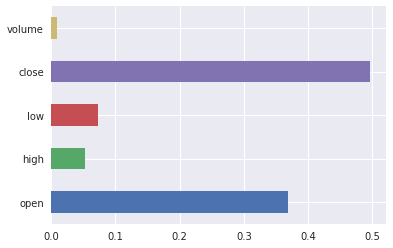

In [20]:
pd.Series(np.abs(clf.coef_[0])/(np.abs(clf.coef_[0]).sum()),index=['open','high','low','close','volume']).plot(kind='barh')

### Decision trees

Idea: greedily build a partition of the input space using cuts orthogonal to feature axes.

In [21]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()

In [22]:
clf.fit(X_train_scaled,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
print('Training accuracy =',np.mean(clf.predict(X_train_scaled)==y_train))
print('Validation accuracy =',np.mean(clf.predict(X_val_scaled)==y_val))

Training accuracy = 1.0
Validation accuracy = 0.5123301459486663


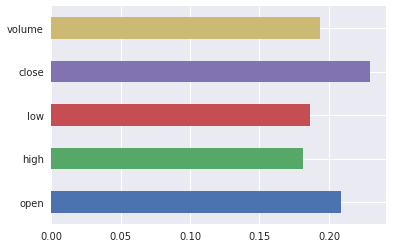

In [24]:
pd.Series(clf.feature_importances_,index=['open','high','low','close','volume']).plot(kind='barh')

### Random Forests

Idea: Build several decision trees with controlled randomness and average their decisions.

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()

In [26]:
clf.fit(X_train_scaled,y_train)

/home/yhuangcc/anaconda3/envs/mafs6010u/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
print('Training accuracy =',np.mean(clf.predict(X_train_scaled)==y_train))
print('Validation accuracy =',np.mean(clf.predict(X_val_scaled)==y_val))

Training accuracy = 0.978213977566868
Validation accuracy = 0.5113236034222446


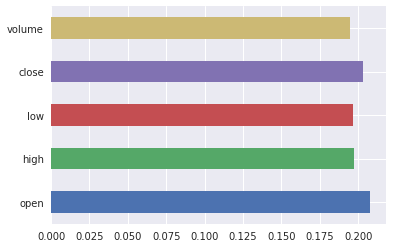

In [28]:
pd.Series(clf.feature_importances_,index=['open','high','low','close','volume']).plot(kind='barh')

### Boosting
Idea: Boosting is an ensemble technique that attempts to create a strong classifier from a number of weak classifiers.

- AdaBoost:
- GradientBoosting: 

#### AdaBoost
AdaBoost is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [29]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier()

In [30]:
clf.fit(X_train_scaled,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [31]:
print('Training accuracy =',np.mean(clf.predict(X_train_scaled)==y_train))
print('Validation accuracy =',np.mean(clf.predict(X_val_scaled)==y_val))

Training accuracy = 0.5125107851596203
Validation accuracy = 0.5093105183694011


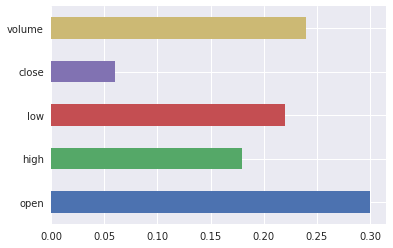

In [32]:
pd.Series(clf.feature_importances_,index=['open','high','low','close','volume']).plot(kind='barh')

#### GradientBoosting
GradientBoosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier()

In [34]:
clf.fit(X_train_scaled,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
print('Training accuracy =',np.mean(clf.predict(X_train_scaled)==y_train))
print('Validation accuracy =',np.mean(clf.predict(X_val_scaled)==y_val))

Training accuracy = 0.709879206212252
Validation accuracy = 0.5118268746854555


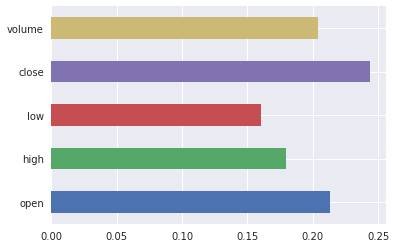

In [36]:
pd.Series(clf.feature_importances_,index=['open','high','low','close','volume']).plot(kind='barh')

# Summary

- Simplest one maybe the best one
- LogisticRegression is the best although little better than random guessing.
- Scikit-Learn provides essential tools for machine learning. 
- It is more than training classifiers!
- Try it for yourself!

# Questions?